In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')

순환 신경망(Recurrent Neural Network, RNN)

순환 신경망은 시퀀스(sequence) 데이터를 사용한다.  
시퀀스 데이터는 다른 말로 시계열(time serise) 데이터라고도 말하며, 시점에 따라 데이터가 달라지는 것을 의미한다. 즉, 특정 시점에서 데이터를 한 번에 수집하는 것이 아닌 시간의 흐름에 따라 데이터를 점차 수집하는 것을 의미한다.  
전체 데이터셋을 구성하는 각 데이터 포인트의 수집 시점이 다른다.

지금까지 다룬 신경망은 입력 데이터를 사용한 후 그 결과가 다시 입력층으로 돌아가지 않았다. 즉, 한 번 출력된 결과는 다시 사용되지 않았다. 이를 피드포워드(feedforward) 신경망이라 한다. 반면에 순환 신경망은 출력된 결과가 다음 시점에 사용된다. 즉, 출력 결과를 다음 시점까지 기억했다가 사용하는 방법이다.

<img src="./data/rnn_1.png" width="700"/>

LSTM(Long Short Merm Memory)  

순환 신경망은 은닉층을 거친 결과값을 재사용한다는 특징이 있다. 그러나 그로 인해서 그래디언트 소실(vanishing gradient problem, 기울기 소멸 문제)이나 그래디언트 폭주 문제(exploding gradient problem, 기울기 폭주 문제)가 발생할 수 있다. 그래디언트 소실 문제는 학습이 진행되는 과정에서 그래디언트가 점점 줄어들어 사라지는 현상을 의미하고 그래디언트 폭주 문제는 학습 과정에서 그래디언트가 점점 커져서 폭주하는 현상을 말한다.

LSTM은 그래디언트 폭주나 소실 문제를 해결하기 위해만든 방법이다. LSTM 에서는 결과값이 다음 시점으로 넘어갈 때 결과값을 넘길지 넘기지 말지 결정하는 단계가 추가된다.

<img src="./data/rnn_2.png" width="700"/>

순환 신경망 실습  
순환 신경망을 이용해 영화 리뷰 감성 분석을 해본다.

In [2]:
# 동일한 결과를 보기 위해 랜덤 시드를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

IMDB Movie Review Sentiment Analysis  
감성 분류를 연습하기 위해 자주 사용하는 영어 데이터로 영화 사이트 IMBD 리뷰 데이터가 있다.  
이 데이터는 리뷰에 대한 텍스트와 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터로 스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있다.

In [3]:
# 데이터 불러오기
from tensorflow.keras import datasets # imdb 영화 리뷰 데이터를 불러오기 위해 import 한다.
# num_words 옵션을 사용해서 이 데이터에서 등장 빈도 순위로 몇 등까지의 단어를 사용할 것인지 지정한다.
# 예를 들어서 10,000을 넣으면, 등장 빈도 순위가 1 ~ 10,000에 해당하는 단어만 사용하게 된다.
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words=2000) # imdb 영화 리뷰 데이터셋을 불러온다.

17473536/17464789 [==============================] - 1s 0us/step


In [4]:
# 오리지널 데이터 차원 확인
# 트레이닝 피쳐 데이터, 트레이닝 테스트 데이터 모두 25,000개의 벡터 데이터로 구성되어 있음을 알 수 있다.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [5]:
# 트레이닝/밸리데이션 셋 분리
# 총 25,000개의 트레이닝 피쳐 데이터 중 20,000개의 데이터를 트레이닝 피쳐 데이터로 지정한다.
X_tr = X_train[:20000]
# 총 25,000개의 트레이닝 피처 데이터 중에서 피쳐 데이터 20,000개를 제외하고 남은 5,000개의 트레이닝 피쳐 데이터를 
# 밸리데이션 피쳐 데이터로 지정한다.
X_valid = X_train[20000:]
print(X_tr.shape, X_valid.shape)
# 총 25,000개의 트레이닝 타겟 데이터 중 20,000개의 데이터를 트레이닝 타겟 데이터로 지정한다.
y_tr = y_train[:20000]
# 총 25,000개의 트레이닝 타겟 데이터 중에서 피쳐 데이터 20,000개를 제외하고 남은 5,000개의 트레이닝 피쳐 데이터를
# 밸리데이션 타겟 데이터로 지정한다.
y_valid = y_train[20000:]
print(y_tr.shape, y_valid.shape)

(20000,) (5000,)
(20000,) (5000,)


In [6]:
# 피쳐 데이터 형태 확인
# 트레이닝 피쳐 데이터 값을 확인해보면 숫자로 이루어진 리스트라는 것을 볼 수 있다.
# 이는 오리지널 데이터에 이미 단어를 숫자 매핑해 놓아 영어 단어가 해당하는 숫자로 변환된 것임을 알 수 있다.
print(X_tr[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [7]:
# 개별 피쳐 데이터 크기 확인
# 피쳐 데이터의 가장 처음 나오는 두 개의 피쳐값을 확인해 본 결과 문장의 길이가 다르다는 것을 의미하며 나중에 같은
# 크기로 조정이 필요한다.
print(len(X_tr[0]))
print(len(X_tr[1]))

218
189


In [8]:
# 타겟 클래스 확인
print(set(y_test)) # 타겟 클래스는 0과 1로 이루어진 이진 분류 문제임을 알 수 있다.
print(len(set(y_test))) # 클래스 구분은 2개로 구분되는 것을 알 수 있다.

{0, 1}
2


In [9]:
# 피쳐 데이터 변형, 제각기 다른 피쳐 데이터 값의 길이를 일치시킨다.
from tensorflow.keras.preprocessing import sequence # 데이터의 길이를 맞추기 위해 import 한다.
# 트레이닝 피쳐 데이터에 대해 pad_sequences() 함수로 maxlen 옵션을 지정해서 길이를 바꿀 수 있다.
# maxlen=100으로 지정하면 단어의 개수가 100개를 넘는 데이터는 100개까지만 저장되고 나머지는 삭제되며 100개가 되지않는
# 데이터는 모자라는 부분은 0으로 채워진다.
X_tr = sequence.pad_sequences(X_tr, maxlen=100)
print(X_tr.shape) # 차원을 확인해보면 길이가 100임을 알 수 있다.
X_valid = sequence.pad_sequences(X_valid, maxlen=100)
print(X_valid.shape)
X_test = sequence.pad_sequences(X_test, maxlen=100)
print(X_test.shape)

(20000, 100)
(5000, 100)
(25000, 100)


In [10]:
# LSTM 신경망 생성에 필요한 라이브러리 import
from tensorflow.keras.models import Sequential # 신경망 모형 생성을 하기 위해 import 한다.
# 각종 층을 쌓기 위해 필요한 모듈을 import 한다.
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D

In [11]:
# LSTM 모형을 만든다.
model = Sequential()
# 임베딩이란 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자의 나열인 벡터로 바꾼 결과 혹은 과정 전체를 의미한다.
# 임베딩이 가장 간단한 형태는 단어의 빈도를 그대로 벡터로 사용하는 것이다.
# 총 2,000개의 단어를 사용하므로 input_dim 옵션은 2,000을 지정하고 데이터 길이는 pad_sequences() 함수를 사용해 
# 100개로 맞췄으므로 output_dim 옵션은 100을 지정한다.
model.add(Embedding(input_dim=2000, output_dim=100)) # 단어 임베딩 층을 추가한다.
# Param은 input_dim * output_dim = 2000 * 100 => 200000
# CNN은 2차원 데이터를 이용하서 Conv2D를 사용했지만 LSTM은 1차원 데이터가 입력되므로 Conv1D를 사용한다.
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='relu')) # 합성곱 층을 추가한다.
# Param은 커널 크기(3) * 입력 채널 수(100) * 필터 수(50) + 출력 채널 바이어스(50) = 3 * 100 * 50 + 50 = 15050
model.add(MaxPooling1D(pool_size=3)) # 맥스 풀링 층을 추가한다.
model.add(LSTM(units=100, activation='tanh')) # LSTM 층을 추가한다. LSTM 층은 4개이다.
# Param은 (출력 개수(100) + 입력 개수(50) + 바이어스(1)) * 출력 개수(100) * 4 = (100 + 50 + 1) * 100 * 4
# = 151 * 100 * 4 = 60400
model.add(Dropout(0.25)) # 드롭아웃 층을 추가한다.
model.add(Dense(1, activation='sigmoid')) # 최종 출력층을 추가해주면 순환 신경망이 완성된다.
# # Param은 입력 개수(100) * 출력 개수(1) + 출력 개수와 같은 바이어스(1) = 100 * 1 + 1 = 101
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         200000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 50)          15050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 50)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 275,551
Trainable params: 275,551
Non-trainable params: 0
__________________________________________________

In [12]:
# 모형 컴파일
# 이진 분류 문제이므로 binary_crossentropy를 사용한다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# 모형 학습
# 트레이닝 데이터를 넣고 미니 배치 사이즈는 100, epoch 10단계로 진행한다.
# 밸리데이션 데이터를 사용할 것이므로 validation_data 옵션으로 검증 데이터를 지정한다.
hist = model.fit(X_tr, y_tr, batch_size=100, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
200/200 [==============================] - 33s 134ms/step - loss: 0.4785 - accuracy: 0.7565 - val_loss: 0.3882 - val_accuracy: 0.8278
Epoch 2/10
200/200 [==============================] - 25s 128ms/step - loss: 0.3425 - accuracy: 0.8542 - val_loss: 0.3734 - val_accuracy: 0.8302
Epoch 3/10
200/200 [==============================] - 25s 127ms/step - loss: 0.3022 - accuracy: 0.8746 - val_loss: 0.3721 - val_accuracy: 0.8320
Epoch 4/10
200/200 [==============================] - 25s 127ms/step - loss: 0.2626 - accuracy: 0.8944 - val_loss: 0.3857 - val_accuracy: 0.8322
Epoch 5/10
200/200 [==============================] - 25s 126ms/step - loss: 0.2101 - accuracy: 0.9223 - val_loss: 0.4413 - val_accuracy: 0.8208
Epoch 6/10
200/200 [==============================] - 26s 128ms/step - loss: 0.1505 - accuracy: 0.9457 - val_loss: 0.4141 - val_accuracy: 0.8226
Epoch 7/10
200/200 [==============================] - 25s 125ms/step - loss: 0.0891 - accuracy: 0.9729 - val_loss: 0.6376 - val_ac

In [14]:
# 모델 평가
print(model.evaluate(X_tr, y_tr))
print(model.evaluate(X_valid, y_valid))
print(model.evaluate(X_test, y_test))

625/625 [==============================] - 14s 20ms/step - loss: 0.0121 - accuracy: 0.9954
[0.012138305231928825, 0.9954000115394592]
157/157 [==============================] - 5s 23ms/step - loss: 0.9451 - accuracy: 0.8060
[0.9451429843902588, 0.8059999942779541]
782/782 [==============================] - 17s 22ms/step - loss: 0.9446 - accuracy: 0.8133
[0.9446051716804504, 0.8132799863815308]


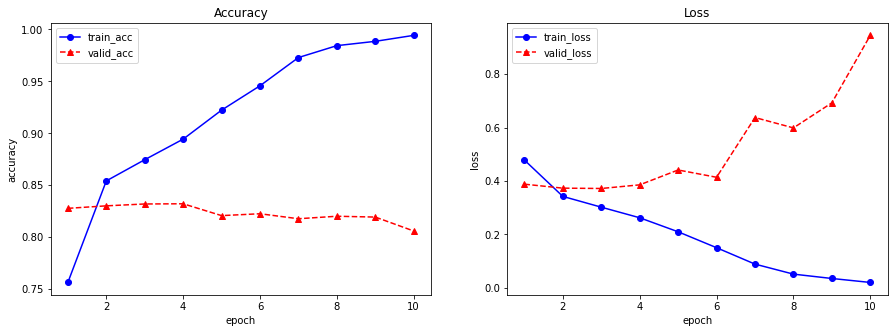

In [15]:
# 정확도/손실 시각화
import numpy as np
epoch = np.arange(1, 11)

acc_train = hist.history['accuracy'] # 트레이닝 데이터의 정확도를 저장한다.
acc_valid = hist.history['val_accuracy'] # 밸리데이션 데이터의 정확도를 저장한다.
loss_train = hist.history['loss'] # 트레이닝 데이터의 손실 정도를 저장한다.
loss_valid = hist.history['val_loss'] # 밸리데이션 데이터의 손실 정도를 저장한다.

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1) # 정확도를 출력할 서브 플롯
plt.plot(epoch, acc_train, 'b', marker='o', label='train_acc')
plt.plot(epoch, acc_valid, 'r--', marker='^', label='valid_acc')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2) # 손실을 출력할 서브 플롯
plt.plot(epoch, loss_train, 'b', marker='o', label='train_loss')
plt.plot(epoch, loss_valid, 'r--', marker='^', label='valid_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()